In [17]:
import obspy
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()
import antropy as ant

In [18]:
def compute_spec_conti(station='SCM'):
    max_v = []
    mean_sxx = []
    df1 = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        f, t, Sxx = signal.spectrogram(a.data, fs, nperseg=50, noverlap=1)
        mean_sxx = np.mean(Sxx[3:8,:], axis=0)
        df1.append(np.array(mean_sxx))
        max_v.append(np.max(mean_sxx[1:-1], axis=0))
        df = pd.DataFrame(np.array(max_v))
        
    return df, df1

def compute_entropy_conti(station='SCM'):
    max_v = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    #stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        entropy = ant.perm_entropy(a)
        max_v.append(entropy)
        df = pd.DataFrame(np.array(max_v))
        
    return df


def compute_centroid_conti(station='SCM'):
    max_v = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        arr1 = abs(np.fft.fft(a))[0:1500]
        arr2 = np.fft.fftfreq(3000,d=1/50)[0:1500]
        centroid = sum(arr1*arr2)/sum(arr1)
        max_v.append(centroid)
        df = pd.DataFrame(np.array(max_v))
        
    return df

def compute_pca_conti(station = 'SCM'):
    max_v = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    arr1 = []
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        arr1.append(abs(abs(np.fft.fft(a))[0:1500]))
    
    
    pca = PCA(3)    
    pca.fit(np.array(arr1).transpose())
    max_v = pca.components_
    df = pd.DataFrame(np.array(max_v))
    return df

    
def plot_spectrogram(station = 'SCM', i =10):
    ev_info = pd.read_csv('Data/SCM_Catalog_Continuous.csv')
    time = obspy.UTCDateTime(ev_info['time'].values[i])
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    #stream.filter('bandpass', freqmin=1, freqmax=10)
    a = stream[2].trim(time, time+300)
    plt.rcParams['figure.figsize'] = 8,5
    plt.figure()
    fig = a.spectrogram(show=False,wlen=1,dbscale=True,cmap='plasma')
    ax = fig.axes[0]
    ax.set_ylim(0.1,25)
    #plt.xlim(0, 100)
    #ax.set_xlim(0,100)
    ax.set_xlabel('Time [s]', fontsize=15, fontweight='bold')
    ax.set_ylabel('Frequency [Hz]', fontsize=15, fontweight='bold')
    ax.set_title('')
    #plt.colorbar(fig)
    plt.tick_params(axis='both', which='major', labelsize=15)
    im = ax.images[0]
    im.set_clim(vmin=-10,vmax=30)
    
def plot_spec_curve(station = 'SCM', i =10):
    ev_info = pd.read_csv('Data/SCM_Catalog_Continuous.csv')
    time = obspy.UTCDateTime(ev_info['time'].values[i])
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    #stream.filter('bandpass', freqmin=1, freqmax=10)
    a = stream[2].trim(time, time+300)
    fs = 50
    f, t, Sxx = signal.spectrogram(a.data, fs, nperseg=50, noverlap=1)
    mean_sxx = np.mean(Sxx[3:8,:], axis=0)
    plt.rcParams['figure.figsize'] = 8,5
    plt.figure()
    plt.plot(mean_sxx)
    #plt.colorbar(fig)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #plt.ylim(0,100)
    
    
def compute_spec_events(station='SCM'):
    max_v = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2]
        fs = 50
        f, t, Sxx = signal.spectrogram(a.data[0:3000], fs, nperseg=50, noverlap=1)
        mean_sxx = np.mean(Sxx[3:8,:], axis=0)
        try:
            max_v.append(np.max(mean_sxx[1:-1], axis=0))
        except ValueError:
            pass
        
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2]
        fs = 50
        f, t, Sxx = signal.spectrogram(a.data[0:3000], fs, nperseg=50, noverlap=1)
        mean_sxx = np.mean(Sxx[3:8,:], axis=0)
        try:
            max_v.append(np.max(mean_sxx[1:-1], axis=0))
        except ValueError:
            pass
    df = pd.DataFrame(np.array(max_v))
    return df

def compute_entropy_events(station='SCM'):
    max_v = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        #st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]

        try:
            max_v.append(ant.perm_entropy(a))
        except ValueError:
            pass
        
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        #st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        try:
            max_v.append(ant.perm_entropy(a))
        except ValueError:
            pass
    df = pd.DataFrame(np.array(max_v))
    return df


def compute_centroid_events(station='SCM'):
    max_v = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        arr1 = abs(np.fft.fft(a))[0:1500]
        arr2 = np.fft.fftfreq(3000,d=1/50)[0:1500]
        try:
            centroid = sum(arr1*arr2)/sum(arr1)
            max_v.append(centroid)
        except ValueError:
            pass
        
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        arr1 = abs(np.fft.fft(a))[0:1500]
        arr2 = np.fft.fftfreq(3000,d=1/50)[0:1500]
        
        try:
            centroid = sum(arr1*arr2)/sum(arr1)
            max_v.append(centroid)
        except ValueError:
            pass
    df = pd.DataFrame(np.array(max_v))
    return df
                    
def compute_pca_events(station='SCM'):
    max_v = []
    arr1 = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        if len(a) == 3000:
            try:
                arr1.append(abs(np.fft.fft(a))[0:1500])  
            except ValueError:
                pass
  
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        if len(a) == 3000:
            try:
                arr1.append(abs(np.fft.fft(a))[0:1500])
            except ValueError:
                pass
                       
    pca = PCA(3)    
    pca.fit(np.array(arr1).transpose())
    max_v = pca.components_
    df = pd.DataFrame(np.array(max_v))  
    return df

In [49]:
stream_scm = obspy.read('Data/Continuous_SCM.mseed')
print(stream_scm)

stream_saw = obspy.read('Data/Continuous_SAW.mseed')
print(stream_saw)

stream_m23k = obspy.read('Data/Continuous_M23K.mseed')
print(stream_m23k)

3 Trace(s) in Stream:
AK.SCM..BHE | 2021-12-01T00:00:00.008400Z - 2021-12-31T00:00:00.006154Z | 50.0 Hz, 129599991 samples
AK.SCM..BHN | 2021-12-01T00:00:00.008400Z - 2021-12-31T00:00:00.006154Z | 50.0 Hz, 129599991 samples
AK.SCM..BHZ | 2021-12-01T00:00:00.008400Z - 2021-12-31T00:00:00.006154Z | 50.0 Hz, 129599991 samples
6 Trace(s) in Stream:
AK.SAW..BHE | 2021-12-01T00:00:00.008400Z - 2021-12-20T10:04:52.468400Z | 50.0 Hz, 83894624 samples
AK.SAW..BHE | 2021-12-20T11:49:47.488400Z - 2021-12-30T23:59:59.988400Z | 50.0 Hz, 45390626 samples
AK.SAW..BHN | 2021-12-01T00:00:00.008400Z - 2021-12-20T10:04:52.468400Z | 50.0 Hz, 83894624 samples
AK.SAW..BHN | 2021-12-20T11:49:47.488400Z - 2021-12-30T23:59:59.988400Z | 50.0 Hz, 45390626 samples
AK.SAW..BHZ | 2021-12-01T00:00:00.008400Z - 2021-12-20T10:04:52.468400Z | 50.0 Hz, 83894624 samples
AK.SAW..BHZ | 2021-12-20T11:49:47.488400Z - 2021-12-30T23:59:59.988400Z | 50.0 Hz, 45390626 samples
6 Trace(s) in Stream:
AK.M23K..BHE | 2021-12-01T00:00

In [19]:
def compute_spec_conti(station='SCM', win = 1, fs = 50):
    max_v = []
    mean_sxx = []
    df1 = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    stream.trim(obspy.UTCDateTime(2021,12,1,0,0,0),obspy.UTCDateTime(2021,12,20,10,0,0))
    stream.filter('bandpass', freqmin=1, freqmax=10)


    for i in tqdm(range(0,len(stream[2].data),int(win*60*fs))):
        try:
            a = stream.select(channel='BHZ')[0].data[i:i+int(win*60*fs)]

            f, t, Sxx = signal.spectrogram(a, fs, nperseg=50, noverlap=0)
            mean_sxx = np.mean(Sxx[3:8,:], axis=0)
            df1.append(np.array(mean_sxx))
            max_v.append(np.max(mean_sxx[1:-1], axis=0))
            df = pd.DataFrame(np.array(max_v))
        except:
            pass
        
    return df, df1

def compute_entropy_conti(station='SCM'):
    max_v = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    #stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        entropy = ant.perm_entropy(a)
        max_v.append(entropy)
        df = pd.DataFrame(np.array(max_v))
        
    return df


def compute_centroid_conti(station='SCM'):
    max_v = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        arr1 = abs(np.fft.fft(a))[0:1500]
        arr2 = np.fft.fftfreq(3000,d=1/50)[0:1500]
        centroid = sum(arr1*arr2)/sum(arr1)
        max_v.append(centroid)
        df = pd.DataFrame(np.array(max_v))
        
    return df

def compute_pca_conti(station = 'SCM'):
    max_v = []
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    stream.filter('bandpass', freqmin=1, freqmax=10)
    fs = 50
    arr1 = []
    for i in tqdm(range(0,len(stream[2].data),3000)):
        a = stream.select(channel='BHZ')[0].data[i:i+3000]
        arr1.append(abs(abs(np.fft.fft(a))[0:1500]))
    
    
    pca = PCA(2)    
    pca.fit(np.array(arr1))
    max_v = pca.components_
    df = pd.DataFrame(np.array(max_v))
    return df

    
def plot_spectrogram(station = 'SCM', i =10):
    ev_info = pd.read_csv('Data/SCM_Catalog_Continuous.csv')
    time = obspy.UTCDateTime(ev_info['time'].values[i])
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    #stream.filter('bandpass', freqmin=1, freqmax=10)
    a = stream[2].trim(time, time+300)
    plt.rcParams['figure.figsize'] = 8,5
    plt.figure()
    fig = a.spectrogram(show=False,wlen=1,dbscale=True,cmap='plasma')
    ax = fig.axes[0]
    ax.set_ylim(0.1,25)
    #plt.xlim(0, 100)
    #ax.set_xlim(0,100)
    ax.set_xlabel('Time [s]', fontsize=15, fontweight='bold')
    ax.set_ylabel('Frequency [Hz]', fontsize=15, fontweight='bold')
    ax.set_title('')
    #plt.colorbar(fig)
    plt.tick_params(axis='both', which='major', labelsize=15)
    im = ax.images[0]
    im.set_clim(vmin=-10,vmax=30)
    
def plot_spec_curve(station = 'SCM', i =10):
    ev_info = pd.read_csv('Data/SCM_Catalog_Continuous.csv')
    time = obspy.UTCDateTime(ev_info['time'].values[i])
    stream = obspy.read('Data/Continuous_'+station+'.mseed')
    #stream.filter('bandpass', freqmin=1, freqmax=10)
    a = stream[2].trim(time, time+300)
    fs = 50
    f, t, Sxx = signal.spectrogram(a.data, fs, nperseg=50, noverlap=0)
    mean_sxx = np.mean(Sxx[3:8,:], axis=0)
    plt.rcParams['figure.figsize'] = 8,5
    plt.figure()
    plt.plot(mean_sxx)
    #plt.colorbar(fig)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #plt.ylim(0,100)
    
    
def compute_spec_events(station='SCM'):
    max_v = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2]
        fs = 50
        f, t, Sxx = signal.spectrogram(a.data[0:3000], fs, nperseg=50, noverlap=0)
        mean_sxx = np.mean(Sxx[3:8,:], axis=0)
        try:
            max_v.append(np.max(mean_sxx[1:-1], axis=0))
        except ValueError:
            pass
        
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2]
        fs = 50
        f, t, Sxx = signal.spectrogram(a.data[0:3000], fs, nperseg=50, noverlap=0)
        mean_sxx = np.mean(Sxx[3:8,:], axis=0)
        try:
            max_v.append(np.max(mean_sxx[1:-1], axis=0))
        except ValueError:
            pass
    df = pd.DataFrame(np.array(max_v))
    return df

def compute_entropy_events(station='SCM'):
    max_v = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        #st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]

        try:
            max_v.append(ant.perm_entropy(a))
        except ValueError:
            pass
        
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        #st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        try:
            max_v.append(ant.perm_entropy(a))
        except ValueError:
            pass
    df = pd.DataFrame(np.array(max_v))
    return df


def compute_centroid_events(station='SCM'):
    max_v = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        arr1 = abs(np.fft.fft(a))[0:1500]
        arr2 = np.fft.fftfreq(3000,d=1/50)[0:1500]
        try:
            centroid = sum(arr1*arr2)/sum(arr1)
            max_v.append(centroid)
        except ValueError:
            pass
        
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        arr1 = abs(np.fft.fft(a))[0:1500]
        arr2 = np.fft.fftfreq(3000,d=1/50)[0:1500]
        
        try:
            centroid = sum(arr1*arr2)/sum(arr1)
            max_v.append(centroid)
        except ValueError:
            pass
    df = pd.DataFrame(np.array(max_v))
    return df
                    
def compute_pca_events(station='SCM'):
    max_v = []
    arr1 = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        if len(a) == 3000:
            try:
                arr1.append(abs(np.fft.fft(a))[0:1500])  
            except ValueError:
                pass
  
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter('bandpass', freqmin=1, freqmax=10)
        a = st[2].data[0:3000]
        if len(a) == 3000:
            try:
                arr1.append(abs(np.fft.fft(a))[0:1500])
            except ValueError:
                pass
                       
    pca = PCA(2)    
    pca.fit(np.array(arr1))
    max_v = pca.components_
    df = pd.DataFrame(np.array(max_v))  
    return df



In [20]:
### saving the maxima peaks in each one minute window for three stations
df_scm, _ = compute_spec_conti(station = 'SCM')
df_saw, _ = compute_spec_conti(station = 'SAW')
df_m23k, _ = compute_spec_conti(station = 'M23K')

100%|██████████| 27960/27960 [00:23<00:00, 1194.18it/s]


In [21]:
## Determining threshold
### Step 1: Compute the statistics of the maxima peaks for the microseismic events.
### Step 2: Remove the outliers. 
### Step 3: Put the threshold to mean/25 %/ 10%
### Step 4: Validation - Find the common picks from all the stations.
### Step 5: Validation - Find the cluster
### Step 6: Match the final peaks with USGS event catalog
### Step 7: Determine the approximate duration and starttime of each events and their characteristics.

In [24]:
### step 1
ev_scm = compute_spec_events(station = 'SCM')
ev_saw = compute_spec_events(station = 'SAW')
ev_m23k = compute_spec_events(station = 'M23K')

100%|██████████| 1057/1057 [00:29<00:00, 36.15it/s]


In [35]:
### step 2 : removing the outliers

evn_scm = ev_scm.values[np.where(ev_scm < ev_scm.quantile(0.9).values[0])[0]]
evn_saw = ev_saw.values[np.where(ev_saw < ev_saw.quantile(0.9).values[0])[0]]
evn_m23k = ev_m23k.values[np.where(ev_m23k < ev_m23k.quantile(0.9).values[0])[0]]

In [597]:
### Computing the threshold
per = 1
thresh_scm = np.percentile(evn_scm,per)
thresh_saw = np.percentile(evn_saw,per)
thresh_m23k = np.percentile(evn_m23k,per)

In [598]:
ind_scm = np.where(df_scm > thresh_scm)[0]
ind_saw = np.where(df_scm > thresh_saw)[0]
ind_m23k = np.where(df_scm > thresh_m23k)[0]

In [609]:
from functools import reduce
#final_ind = reduce(np.intersect1d,(ind_scm, ind_saw, ind_m23k))
final_ind = np.intersect1d(ind_scm, ind_saw)
#final_ind = ind_scm

In [610]:
### pca validation remaining.

In [611]:
file = 'Data/SCM_catalog_1500_all.csv'
cat = pd.read_csv(file)
cat_times = pd.read_csv(file)['time']
cat_depths = pd.read_csv(file)['depth']
cat_lons = pd.read_csv(file)['longitude']
cat_lats = pd.read_csv(file)['latitude']

In [612]:
cat_dist = []
for i in tqdm(range(len(cat_times))):
    cat_dist.append(gps2dist_azimuth(cat_lats[i], cat_lons[i], scm_lat, scm_lon)[0]/(111*1000))
cat_dist = np.array(cat_dist)
dist_c = 200

ind_dist = np.where(np.array(cat_dist) < dist_c/111)[0]

c_times  = cat_times[ind_dist]
c_depths = cat_depths[ind_dist]
c_lons = np.array(cat_lons[ind_dist])
c_lats = np.array(cat_lats[ind_dist])
c_dist  = np.array(cat_dist[ind_dist])

100%|██████████| 2173/2173 [00:00<00:00, 6537.20it/s]


In [613]:
len(c_dist)

535

In [614]:
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

cat_ind = []
for i in tqdm(range(len(c_times))):
    if c_depths[ind_dist[i]] < 0:
        c_depths[ind_dist[i]] = 0
        
    #arrivals = model.get_travel_times(source_depth_in_km=c_depths[ind_dist[i]],
     #                                 distance_in_degree=c_dist[i])    
    
    t1 = obspy.UTCDateTime(c_times[ind_dist[i]])#+arrivals[0].time
    t2 = obspy.UTCDateTime(2021,12,1,0,0,0)
    cat_ind.append(round((t1-t2)/60))

100%|██████████| 535/535 [00:00<00:00, 24864.84it/s]


In [615]:
cat_ind = np.array(cat_ind)
common = np.intersect1d(cat_ind,final_ind)

com_ind = []

for i in range(len(common)):
    com_ind.append(list(cat_ind).index(common[i]))
    
com_ind = np.array(com_ind)



ev_lat = c_lats[com_ind]
ev_lon = c_lons[com_ind]
scm_lat, scm_lon = 61.832001,-147.328995
dist = []
from obspy.geodetics.base import gps2dist_azimuth
for i in range(len(ev_lat)):
    dist.append(gps2dist_azimuth(ev_lat[i], ev_lon[i], scm_lat, scm_lon)[0]/1000)
    


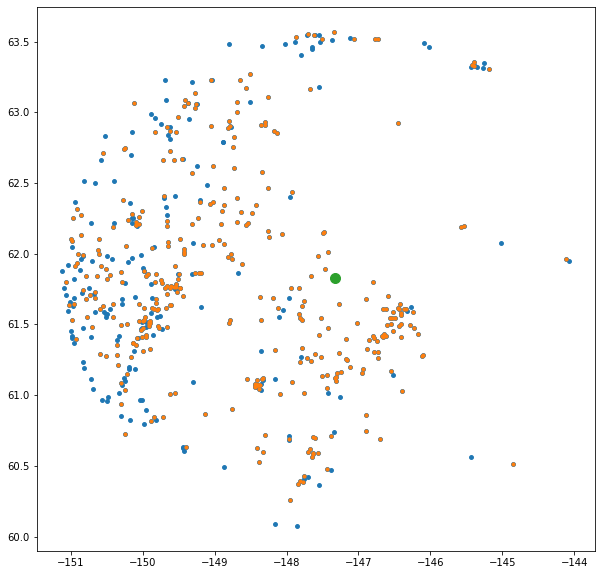

In [616]:
plt.figure(figsize=[10,10])

plt.scatter(c_lons, c_lats,s=15)
plt.scatter(ev_lon, ev_lat, s=10)
plt.scatter(scm_lon, scm_lat, s=100)

In [617]:
print(len(common))
print(len(ind_scm))
print(len(common)/len(cat_ind)*100)

353
2819
65.98130841121495


In [619]:
cat_times

0       2021-12-20T09:55:48.948Z
1       2021-12-20T09:46:54.081Z
2       2021-12-20T09:42:44.234Z
3       2021-12-20T09:41:09.606Z
4       2021-12-20T09:26:37.467Z
                  ...           
2168    2021-12-01T01:24:46.867Z
2169    2021-12-01T00:57:33.800Z
2170    2021-12-01T00:27:00.786Z
2171    2021-12-01T00:12:18.959Z
2172    2021-12-01T00:06:04.125Z
Name: time, Length: 2173, dtype: object

In [624]:
from obspy.clients.fdsn import Client

In [656]:
client = Client('IRIS')

for i in tqdm(range(len(cat_times))):
    st = client.get_waveforms(network='AK',location='*',station='SCM',channel= 'BH*', starttime=obspy.UTCDateTime(cat_times[i])-10, 
                          endtime = obspy.UTCDateTime(cat_times[i])+300)
    st.write('Data/detection_waveforms/SCM_'+str(i)+'.mseed')

100%|██████████| 2173/2173 [21:05<00:00,  1.72it/s]


In [629]:
obspy.read('Data/detection_waveforms/SCM_1.mseed')[2]

AK.SCM..BHZ | 2021-12-20T09:46:44.088400Z - 2021-12-20T09:48:34.068400Z | 50.0 Hz, 5500 samples

In [633]:
cat

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-12-20T09:55:48.948Z,67.313700,-156.161500,0.80,1.40,ml,NaN,NaN,NaN,0.59,...,2022-01-28T19:58:58.814Z,"55 km NE of Kobuk, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
1,2021-12-20T09:46:54.081Z,54.868200,-160.330300,21.70,2.00,ml,NaN,NaN,NaN,0.58,...,2022-01-28T19:58:58.565Z,"53 km SSE of Sand Point, Alaska",earthquake,NaN,0.90,NaN,NaN,reviewed,ak,ak
2,2021-12-20T09:42:44.234Z,67.333800,-156.188300,12.00,2.70,ml,NaN,NaN,NaN,0.60,...,2022-03-01T16:38:14.040Z,"56 km NNE of Kobuk, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
3,2021-12-20T09:41:09.606Z,64.665700,-147.750200,15.20,1.10,ml,NaN,NaN,NaN,0.55,...,2022-01-28T19:58:58.308Z,"16 km S of South Van Horn, Alaska",earthquake,NaN,0.10,NaN,NaN,reviewed,ak,ak
4,2021-12-20T09:26:37.467Z,63.182900,-150.199100,86.50,1.30,ml,NaN,NaN,NaN,0.77,...,2022-01-28T19:58:58.047Z,"66 km WSW of Cantwell, Alaska",earthquake,NaN,0.70,NaN,NaN,reviewed,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,2021-12-01T01:24:46.867Z,61.259100,-151.868100,90.70,1.50,ml,NaN,NaN,NaN,0.39,...,2022-01-05T23:05:49.792Z,Southern Alaska,earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
2169,2021-12-01T00:57:33.800Z,58.177333,-155.377167,0.94,-0.33,ml,4.0,225.0,NaN,0.05,...,2021-12-02T07:03:31.890Z,"87 km NW of Karluk, Alaska",earthquake,0.87,1.23,0.19922,4.0,reviewed,av,av
2170,2021-12-01T00:27:00.786Z,59.930800,-151.905900,73.40,2.00,ml,NaN,NaN,NaN,0.43,...,2022-01-05T23:05:49.453Z,"Kenai Peninsula, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
2171,2021-12-01T00:12:18.959Z,60.084200,-153.004300,127.10,1.90,ml,NaN,NaN,NaN,0.31,...,2022-01-05T23:06:08.487Z,"69 km ENE of Pedro Bay, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak


In [674]:
snr = []
for i in tqdm(range(len(cat_times))):
    if cat_depths[i] < 0:
        cat_depths[i] = 0
    st = obspy.read('Data/detection_waveforms/SCM_'+str(i)+'.mseed')
    arrivals = model.get_travel_times(source_depth_in_km=cat_depths[i],
                                     distance_in_degree=cat_dist[i])
    
    noise = st[2].data
    signal = st[2].data[int(50*(10+arrivals[0].time)):int(50*(10+arrivals[0].time)+500)]
    snr.append(max(abs(signal))/np.std(abs(noise)))

100%|██████████| 2173/2173 [07:53<00:00,  4.59it/s]


In [675]:
cat['SNR'] = snr

In [676]:
cat['Distance'] = cat_dist

In [677]:
cat

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,SNR,Distance
0,2021-12-20T09:55:48.948Z,67.313700,-156.161500,0.80,1.40,ml,NaN,NaN,NaN,0.59,...,earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak,5.070802,6.683926
1,2021-12-20T09:46:54.081Z,54.868200,-160.330300,21.70,2.00,ml,NaN,NaN,NaN,0.58,...,earthquake,NaN,0.90,NaN,NaN,reviewed,ak,ak,5.567668,9.757377
2,2021-12-20T09:42:44.234Z,67.333800,-156.188300,12.00,2.70,ml,NaN,NaN,NaN,0.60,...,earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak,2.944894,6.706179
3,2021-12-20T09:41:09.606Z,64.665700,-147.750200,15.20,1.10,ml,NaN,NaN,NaN,0.55,...,earthquake,NaN,0.10,NaN,NaN,reviewed,ak,ak,3.609134,2.851944
4,2021-12-20T09:26:37.467Z,63.182900,-150.199100,86.50,1.30,ml,NaN,NaN,NaN,0.77,...,earthquake,NaN,0.70,NaN,NaN,reviewed,ak,ak,5.234595,1.900925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,2021-12-01T01:24:46.867Z,61.259100,-151.868100,90.70,1.50,ml,NaN,NaN,NaN,0.39,...,earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak,2.943574,2.248815
2169,2021-12-01T00:57:33.800Z,58.177333,-155.377167,0.94,-0.33,ml,4.0,225.0,NaN,0.05,...,earthquake,0.87,1.23,0.19922,4.0,reviewed,av,av,4.037554,5.453846
2170,2021-12-01T00:27:00.786Z,59.930800,-151.905900,73.40,2.00,ml,NaN,NaN,NaN,0.43,...,earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak,3.532709,2.941116
2171,2021-12-01T00:12:18.959Z,60.084200,-153.004300,127.10,1.90,ml,NaN,NaN,NaN,0.31,...,earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak,3.845296,3.277299


In [678]:
cat.to_csv('Data/detection_cat.csv', index=False)

In [679]:
cat['SNR'].describe()

count    2173.000000
mean        5.952101
std         3.213290
min         0.330938
25%         3.954294
50%         5.096672
75%         6.967351
max        51.651877
Name: SNR, dtype: float64

In [653]:
len(st[2].data)

5500

In [646]:
arrivals[0].time

139.00782530788868

In [648]:
cat_dist

array([ 6.68392551,  9.7573769 ,  6.70617896, ...,  2.94111555,
        3.27729867,  3.15914819])

In [654]:
arrivals = model.get_travel_times(source_depth_in_km=cat_depths[i],
                                     distance_in_degree=15)

In [655]:
arrivals[0].time

210.59810375432423

In [430]:
common = np.intersect1d(cat_ind,final_ind)

In [431]:
com_ind = []

for i in range(len(common)):
    com_ind.append(list(cat_ind).index(common[i]))

In [432]:
com_ind = np.array(com_ind)

In [433]:
cat['mag'][com_ind].describe()

count    311.000000
mean       1.964984
std        0.684038
min       -0.420000
25%        1.500000
50%        1.900000
75%        2.300000
max        4.700000
Name: mag, dtype: float64

In [434]:
cat['depth'][com_ind].describe()

count    311.000000
mean      48.147428
std       39.003561
min        0.000000
25%       14.500000
50%       37.600000
75%       75.750000
max      163.000000
Name: depth, dtype: float64

In [435]:
ev_lat = cat['latitude'][com_ind].values
ev_lon = cat['longitude'][com_ind].values
scm_lat, scm_lon = 61.832001,-147.328995
dist = []
from obspy.geodetics.base import gps2dist_azimuth
for i in range(len(ev_lat)):
    dist.append(gps2dist_azimuth(ev_lat[i], ev_lon[i], scm_lat, scm_lon)[0]/1000)

In [436]:
pd.DataFrame(dist).quantile(0.9)

0    411.351027
Name: 0.9, dtype: float64

In [437]:
pd.DataFrame(dist).describe()

,0
count,311.000000
mean,230.598287
std,197.252578
min,9.856041
25%,110.912270
50%,190.072549
75%,295.299568
max,1445.479405


In [438]:
len(ind_scm)

1045

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


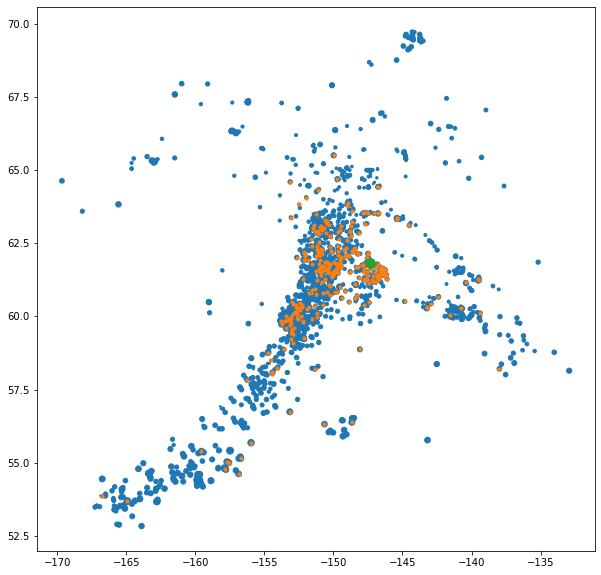

In [439]:
plt.figure(figsize=[10,10])

plt.scatter(cat['longitude'], cat['latitude'],s=cat['mag'].values*10)
plt.scatter(ev_lon, ev_lat, s=10)
plt.scatter(scm_lon, scm_lat, s=100)

In [440]:
len(np.where(cat['mag'].values <3)[0])

2104

In [441]:
len(common)

311

In [442]:
len(final_ind)

669

In [292]:
len(df_scm)

27960

In [229]:
df_m23k.describe()

,0
count,2.796000e+04
mean,1.769337e+07
std,1.507371e+09
min,1.203639e+00
25%,1.293516e+01
50%,3.585464e+01
75%,9.363098e+01
max,1.804722e+11


In [207]:
ev_scm.describe()

,0
count,4.475000e+03
mean,1.239508e+05
std,2.765622e+06
min,1.381141e+00
25%,7.606967e+01
50%,2.018181e+02
75%,8.547429e+02
max,1.498066e+08


In [232]:
df_m23k.quantile(0.9)

0    268.160469
Name: 0.9, dtype: float64

In [11]:
pca_noise = compute_pca_conti()
pca_events = compute_pca_events()

100%|██████████| 2044/2044 [00:55<00:00, 36.50it/s]


In [12]:
pca_noise

,0,1,2,3,4,5,6,7,8,9,...,43190,43191,43192,43193,43194,43195,43196,43197,43198,43199
0,0.000178,0.000044,0.000038,0.000053,0.000039,0.000042,0.000039,0.000046,0.000040,0.000051,...,0.000019,0.000019,0.000018,0.000028,0.000020,0.000021,0.000016,0.000018,0.000020,0.000018
1,0.000016,0.000029,0.000026,0.000054,0.000033,0.000043,0.000026,0.000032,0.000040,0.000052,...,0.000007,0.000014,0.000011,0.000012,0.000013,0.000006,0.000012,0.000013,0.000014,0.000014
2,0.000099,0.000322,0.000316,0.000251,0.000312,0.000271,0.000225,0.000287,0.000338,0.000335,...,0.000084,0.000092,0.000110,0.000082,0.000092,0.000123,0.000099,0.000102,0.000083,0.000124


<IPython.core.display.Javascript object>


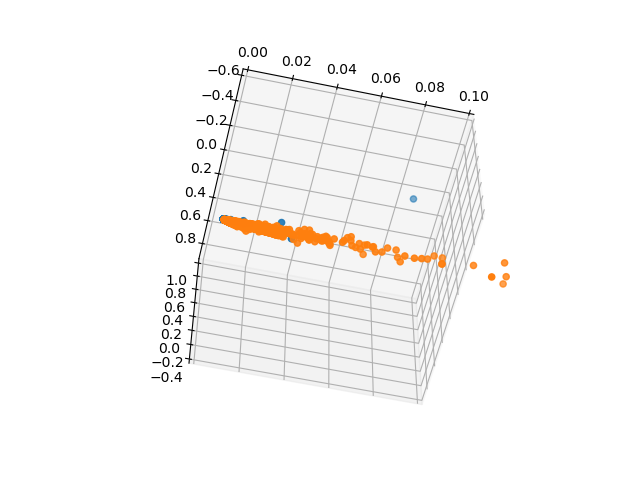

(0.0, 0.1)

In [16]:
xn = pca_noise.values[0,:]
yn = pca_noise.values[1,:]
zn = pca_noise.values[2,:]

xe = pca_events.values[0,:]
ye = pca_events.values[1,:]
ze = pca_events.values[2,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xn, yn, zn, marker='o')
ax.scatter(xe, ye, ze, marker='o')
ax.set_xlim(0, 0.1)

<IPython.core.display.Javascript object>


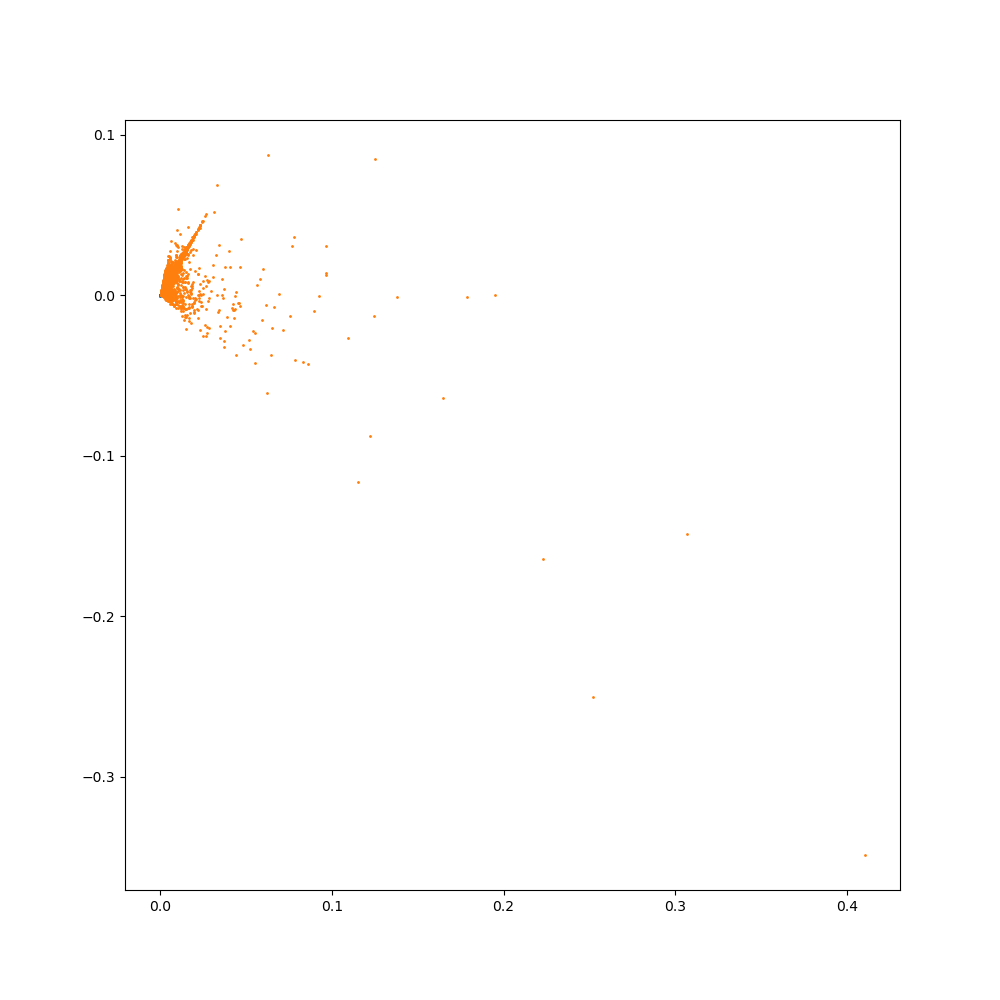

In [43]:
plt.figure(figsize=[10,10])

plt.scatter(x_n,y_n, s=1)
plt.scatter(xe,ye, s=1)

#plt.xlim(0,0.02)
#plt.ylim(-0.001,0.008)

In [33]:
dfxn = pd.DataFrame(xn)
dfyn = pd.DataFrame(yn)
dfxn.quantile(0.9)

0    0.000051
Name: 0.9, dtype: float64

In [34]:
ind_xn  = np.where(xn < dfxn.quantile(0.9).values)
ind_yn  = np.where(yn < dfyn.quantile(0.9).values)

In [37]:
ind_n = np.intersect1d(ind_xn, ind_yn)

In [41]:
x_n = xn[ind_n]
y_n = yn[ind_n]
